## Loading Data

In [0]:
import os
import uuid 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.multioutput import MultiOutputRegressor
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
import warnings
warnings. filterwarnings('ignore')

In [92]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
data_path = '/content/drive/My Drive/Colab Notebooks/cabspottingdata'
txt_file_names = os.listdir(data_path)

taxi_dfs = []

for file_name in txt_file_names[:10]:
    data = pd.read_csv(os.path.join(data_path, file_name), sep=' ', 
                   header=None, names = ['latitude', 'longitude', 'occupancy', 'time'])
    data['time'] = pd.to_datetime(data['time'], unit='s')
    data['taxi_id'] = file_name.split('.')[0]
    taxi_dfs.append(data)


In [0]:
data = pd.concat(taxi_dfs, ignore_index=True)

In [96]:
len(data)

226925

In [97]:
data.head()

,latitude,longitude,occupancy,time,taxi_id
0,37.78615,-122.40628,1,2008-05-17 10:00:42,new_auctjir
1,37.78620,-122.40181,1,2008-05-17 10:01:43,new_auctjir
2,37.78629,-122.39917,1,2008-05-17 10:02:43,new_auctjir
3,37.78618,-122.40140,1,2008-05-17 10:03:53,new_auctjir
4,37.78655,-122.40231,1,2008-05-17 10:04:54,new_auctjir


## Preprocessing Data

#### Calculation of Geographical Distance

Previous work with GPS trace data and distances mostly
considered Euclidian distance between two points. However,
this calculation completely ignores the fact that the earth is
round yielding incorrect results. Of all available methods Equi-rectangular approximation is preferred
for faster system performance.

Equirectangular approximation
Formula hear
Here, R is the radius of earth (6371 km).

In [0]:
EARTH_RADIUS = 6371  # km

In [0]:
prev_occupancy = data.iloc[0, data.columns.get_loc('occupancy')]
prev_taxi_id = data.iloc[0, data.columns.get_loc('taxi_id')]
trip_id = uuid.uuid4()
data['trip_id'] = ''
data['drop_off_latitude'] = ''
data['drop_off_longitude'] = ''
data['drop_off_time']  = ''
for index, row in data.iterrows():
    # generating trip id's for consecutive trips of with or without passenger
    if row['occupancy'] != prev_occupancy or row['taxi_id'] != prev_taxi_id:
        trip_id = uuid.uuid4()
        data.iloc[index, data.columns.get_loc('trip_id')] = trip_id
        data.iloc[index-1, data.columns.get_loc('drop_off_latitude')] = row['latitude']
        data.iloc[index-1, data.columns.get_loc('drop_off_longitude')] = row['longitude']
        data.iloc[index-1, data.columns.get_loc('drop_off_time')] = row['time']
    else:
        data.iloc[index, data.columns.get_loc('trip_id')] = trip_id
    prev_occupancy, prev_taxi_id = row['occupancy'], row['taxi_id']
data.iloc[-1, data.columns.get_loc('drop_off_latitude')] = data.iloc[-1, data.columns.get_loc('latitude')]
data.iloc[-1, data.columns.get_loc('drop_off_longitude')] = data.iloc[-1, data.columns.get_loc('longitude')]
data.iloc[-1, data.columns.get_loc('drop_off_time')] = data.iloc[-1, data.columns.get_loc('time')]

In [11]:
data.head()

,latitude,longitude,occupancy,time,taxi_id,trip_id,drop_off_latitude,drop_off_longitude,drop_off_time
0,37.78615,-122.40628,1,2008-05-17 10:00:42,new_auctjir,1b36ff61-7029-4ae3-936b-34d1787dcf0b,,,
1,37.78620,-122.40181,1,2008-05-17 10:01:43,new_auctjir,1b36ff61-7029-4ae3-936b-34d1787dcf0b,,,
2,37.78629,-122.39917,1,2008-05-17 10:02:43,new_auctjir,1b36ff61-7029-4ae3-936b-34d1787dcf0b,,,
3,37.78618,-122.40140,1,2008-05-17 10:03:53,new_auctjir,1b36ff61-7029-4ae3-936b-34d1787dcf0b,,,
4,37.78655,-122.40231,1,2008-05-17 10:04:54,new_auctjir,1b36ff61-7029-4ae3-936b-34d1787dcf0b,,,


In [0]:
# Aggregating functions

def total_dist(group):
    lat = np.radians(group.latitude)
    lon = np.radians(group.longitude)
    endLon = lon.shift(-1, fill_value=np.radians(group['drop_off_longitude'].iloc[-1]))
    endLat = lat.shift(-1, fill_value=np.radians(group['drop_off_latitude'].iloc[-1]))
    x = (endLon - lon) * np.cos(0.5 * (endLat + lat))
    y = endLat - lat
    D = EARTH_RADIUS * np.sqrt(x ** 2 + y ** 2)
    return D.sum()

def total_duration(group):
    start_time = group['time']
    end_time = start_time.shift(-1, fill_value=group['drop_off_time'].iloc[-1])
    durations = (end_time - start_time).astype('timedelta64[s]')/60
    return durations.sum()

def first_record_of_column(group, column):
    return group.iloc[0, group.columns.get_loc(column)]

def last_record_of_column(group, column):
    return group.iloc[-1, group.columns.get_loc(column)]

def trip_statistics(trip):
    return pd.Series({"taxi_id": first_record_of_column(trip, 'taxi_id'),
                      "distance": total_dist(trip),
                      "duration": total_duration(trip),
                      "start_longitude": first_record_of_column(trip, 'longitude'),
                      "start_latitude": first_record_of_column(trip, 'latitude'),
                      "end_longitude": last_record_of_column(trip, 'longitude'),
                      "end_latitude": last_record_of_column(trip, 'latitude'),
                      "occupancy": first_record_of_column(trip, 'occupancy'),
                      "start_time": first_record_of_column(trip, 'time'),
                      "end_time": last_record_of_column(trip, 'time'),
                      "No. of Waypoints": len(trip)})

In [0]:
aggregated_data = data.groupby("trip_id").apply(trip_statistics)

In [14]:
aggregated_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1880 entries, 0001e4d0-e053-4dda-9e0a-d2f042f122ae to ffcaefc6-b5e3-405f-8f08-68c2be8a5d8e
Data columns (total 11 columns):
taxi_id             1880 non-null object
distance            1880 non-null float64
duration            1880 non-null float64
start_longitude     1880 non-null float64
start_latitude      1880 non-null float64
end_longitude       1880 non-null float64
end_latitude        1880 non-null float64
occupancy           1880 non-null int64
start_time          1880 non-null datetime64[ns]
end_time            1880 non-null datetime64[ns]
No. of Waypoints    1880 non-null int64
dtypes: datetime64[ns](2), float64(6), int64(2), object(1)
memory usage: 176.2+ KB


In [0]:
KM2MILE = 0.621
AVERAGE_EMISSION = 404 # gram
TAXI_FLEET_CHANGE_RATE = 0.1

In [0]:
aggregated_data['emission'] = aggregated_data['distance'] * KM2MILE * AVERAGE_EMISSION

In [0]:
free_ride_emission = aggregated_data[aggregated_data['occupancy'] == 0].groupby("taxi_id").sum()['emission']

In [0]:
free_ride_emission = free_ride_emission.sort_values(ascending=False)

In [19]:
free_ride_emission

taxi_id
new_auctjir    1.070846e+06
Name: emission, dtype: float64

In [0]:
yearly_replacment_count = int(free_ride_emission.shape[0] * (1 - (1 - TAXI_FLEET_CHANGE_RATE) ** 12))

In [21]:
yearly_replacment_count

0

### Question 1. Yearly Potential Reduction of CO2 Emmission

In [22]:
free_ride_emission.iloc[:yearly_replacment_count].sum()

0.0

Here, we can see the plot of average trip duration depending on occupancy. Non-occupied Average trip duration is greater than occupied average trip duration.

In [23]:
aggregated_data['occupancy'].value_counts()

1    940
0    940
Name: occupancy, dtype: int64

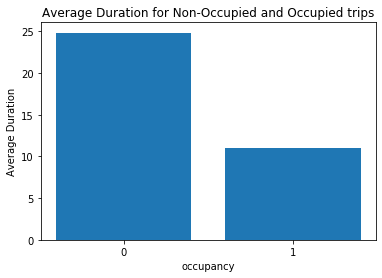

In [24]:
plot_duration = aggregated_data.groupby('occupancy')['duration'].mean()
plt.bar(plot_duration.index, plot_duration.values)
plt.xticks(plot_duration.index)
plt.title("Average Duration for Non-Occupied and Occupied trips")
plt.xlabel('occupancy')
plt.ylabel('Average Duration')
plt.show();

We can see that average distance is greater for occupied trips.

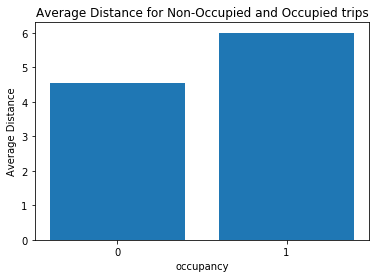

In [25]:
plot_distance = aggregated_data.groupby('occupancy')['distance'].mean()
plt.bar(plot_distance.index, plot_distance.values)
plt.xticks(plot_distance.index)
plt.title("Average Distance for Non-Occupied and Occupied trips")
plt.xlabel('occupancy')
plt.ylabel('Average Distance')
plt.show();

In [26]:
aggregated_data['duration'].describe()

count    1880.000000
mean       17.887713
std        55.607318
min         0.016667
25%         3.966667
50%         8.083333
75%        14.795833
max      1004.166667
Name: duration, dtype: float64

From boxplot we can see that the duration is not normally distributed

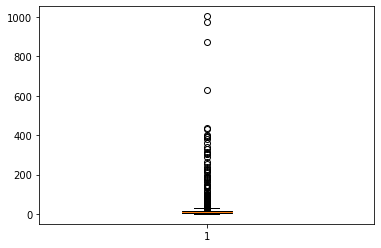

In [27]:
plt.boxplot(aggregated_data['duration']);

Pick-up Longitude and Latitude of San Francisco

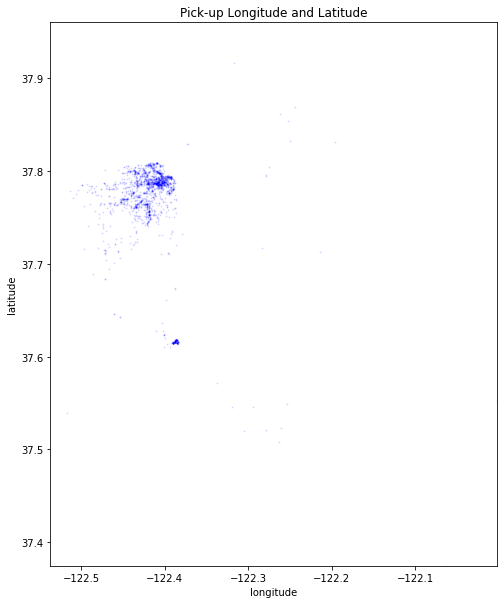

In [28]:
city_long_border = (aggregated_data['start_longitude'].min(), aggregated_data['start_longitude'].max())
city_lat_border = (aggregated_data['start_latitude'].min(), aggregated_data['start_latitude'].max())
plt.figure(figsize=(8,10))
plt.scatter(aggregated_data['start_longitude'].values, aggregated_data['start_latitude'].values,
              color='blue', s=1, alpha=0.1)
plt.title('Pick-up Longitude and Latitude')
plt.ylabel('latitude')
plt.xlabel('longitude')
plt.ylim(city_lat_border)
plt.xlim(city_long_border)
plt.show()

In [29]:
aggregated_data.head()

,taxi_id,distance,duration,start_longitude,start_latitude,end_longitude,end_latitude,occupancy,start_time,end_time,No. of Waypoints,emission
trip_id,,,,,,,,,,,,
0001e4d0-e053-4dda-9e0a-d2f042f122ae,new_auctjir,1.292630,6.166667,-122.39634,37.78547,-122.39538,37.77670,0,2008-06-09 16:40:27,2008-06-09 16:46:29,7,324.300111
002086e7-1f87-4262-bf20-3a401aafcb86,new_auctjir,1.149832,37.683333,-122.38535,37.61778,-122.38729,37.61532,0,2008-06-08 21:46:01,2008-06-08 22:14:57,15,288.474556
00238d7a-0c1f-4c76-9301-603446a1e663,new_auctjir,15.314141,433.383333,-122.45403,37.70604,-122.46133,37.64635,0,2008-05-23 09:01:44,2008-05-23 09:33:09,36,3842.072948
008efe4f-a155-4853-a42f-43deb0243914,new_auctjir,0.006332,0.666667,-122.43810,37.77610,-122.43812,37.77609,1,2008-05-18 16:35:06,2008-05-18 16:35:39,2,1.588605
0154a2a8-5b29-4e22-9a84-9a58932212ec,new_auctjir,1.600678,6.050000,-122.49982,37.78504,-122.48674,37.77706,0,2008-05-18 17:36:38,2008-05-18 17:41:42,7,401.584442


### Missing values

Knowing about missing values is important because they indicate how much we don’t know about our data. Making inferences based on just a few cases is often unwise. In addition, many modelling procedures break down when missing values are involved and the corresponding rows will either have to be removed completely or the values need to be estimated somehow.

Here, we are in the fortunate position that our data is complete and there are no missing values:

In [30]:
print(data.isnull().sum())

latitude              0
longitude             0
occupancy             0
time                  0
taxi_id               0
trip_id               0
drop_off_latitude     0
drop_off_longitude    0
drop_off_time         0
dtype: int64


### Feature Addition

In [0]:
def add_datetime_features(df, date_time_column):
    #Convert to datetime format
    
    df['hour'] = df[date_time_column].dt.hour
    df['day'] = df[date_time_column].dt.day
    df['weekday'] = df[date_time_column].dt.weekday
    
    return df

df = add_datetime_features(aggregated_data, 'start_time')

In [0]:
hour_bins = [-1, 5, 7, 10, 16, 21, 23]
bin_names = ['late_night', 'morning', 'morning_peak', 'afternoon', 'evening', 'night']
df['hour_type'] = pd.cut(df.hour, bins=hour_bins, labels=bin_names).cat.codes

In [0]:
df['speed'] = df['distance'] / (df['duration'] / 60) 

In [0]:
df = df.sort_values(by=['taxi_id', 'start_time'])
df = df[df['occupancy'] == 1]

In [49]:
df.head()

,taxi_id,distance,duration,start_longitude,start_latitude,end_longitude,end_latitude,occupancy,start_time,end_time,No. of Waypoints,emission,hour,day,weekday,hour_type,speed,pickup_cluster
trip_id,,,,,,,,,,,,,,,,,,
1b36ff61-7029-4ae3-936b-34d1787dcf0b,new_auctjir,1.116158,4.550000,-122.40628,37.78615,-122.40332,37.78821,1,2008-05-17 10:00:42,2008-05-17 10:05:09,6,280.026235,10,17,5,2,14.718570,18
060ba53b-8808-473b-be76-b2bcb84b15c6,new_auctjir,1.566277,4.833333,-122.40537,37.79752,-122.41969,37.80489,1,2008-05-17 10:07:45,2008-05-17 10:12:34,6,392.953718,10,17,5,2,19.443433,28
32c9e7f5-fdb3-4293-89db-2e892838cb30,new_auctjir,10.718438,18.200000,-122.41817,37.80609,-122.46640,37.76566,1,2008-05-17 10:15:42,2008-05-17 10:33:52,20,2689.084486,10,17,5,2,35.335508,11
5c72909a-086e-43b4-8e74-36e3bf3ec30e,new_auctjir,0.001112,0.016667,-122.47202,37.71512,-122.47202,37.71512,1,2008-05-17 10:47:15,2008-05-17 10:47:15,1,0.278970,10,17,5,2,4.003017,26
920908ae-a20f-4131-bda8-addd765dc632,new_auctjir,0.091218,0.066667,-122.47129,37.71188,-122.47129,37.71188,1,2008-05-17 10:47:31,2008-05-17 10:47:31,1,22.885142,10,17,5,2,82.096220,26


#### Outlier removal



In [50]:
print(len(df))
df = df[df['speed'] <= 300]
print(len(df))

939
939


## Clustering

### K-means clustering

Determining the optimal number of clusters


In [0]:
coords = df[['start_latitude', 'start_longitude']].values

Silhouette score for different values of K

In [0]:
s_score = []
for i in range(2,40):
  km1 = MiniBatchKMeans(n_clusters=i, batch_size=1000 , random_state = 1).fit(coords)
  score = silhouette_score(X = coords, labels = km1.labels_)
  s_score = np.append(s_score, score)

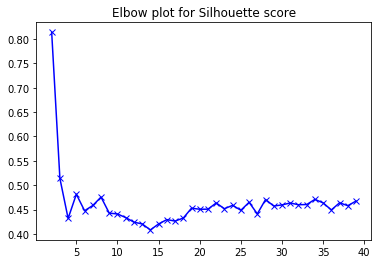

In [53]:
plt.plot(range(2,40), s_score, 'bx-')
plt.title('Elbow plot for Silhouette score');

We can choose 35 clusters for our task, since silhouette score is remaining the same after that cluster

In [0]:
kmeans = MiniBatchKMeans(n_clusters=35, batch_size=1000, random_state=1).fit(coords)
df['pickup_cluster'] = kmeans.predict(coords)

In [0]:
cluster_centers = kmeans.cluster_centers_
cluster_len = len(cluster_centers)

In [57]:
cluster_len

35

Map based on clusters

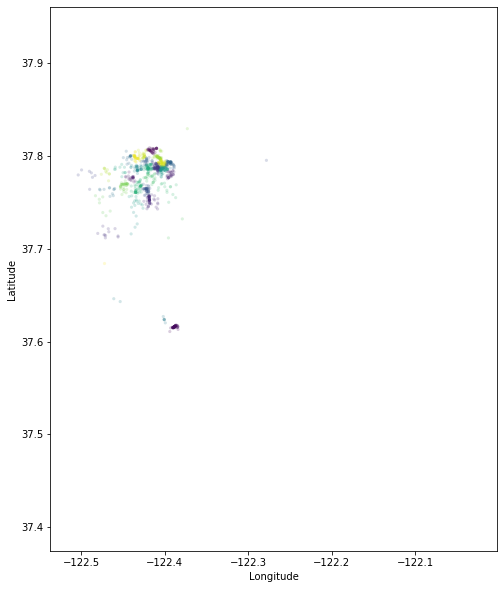

In [58]:
plt.figure(figsize=(8,10))
plt.scatter(df['start_longitude'].values, df['start_latitude'].values, s=10, lw=0,
           c=df['pickup_cluster'].values, alpha=0.2)
plt.xlim(city_long_border)
plt.ylim(city_lat_border)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [0]:
# saving our result df to csv
# df.to_csv('/content/drive/My Drive/Colab Notebooks/data.csv')
# data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/data.csv')
# data.head()

## Modeling

### Multivariate Regression and XGBoost

In [59]:
df.head()

,taxi_id,distance,duration,start_longitude,start_latitude,end_longitude,end_latitude,occupancy,start_time,end_time,No. of Waypoints,emission,hour,day,weekday,hour_type,speed,pickup_cluster
trip_id,,,,,,,,,,,,,,,,,,
1b36ff61-7029-4ae3-936b-34d1787dcf0b,new_auctjir,1.116158,4.550000,-122.40628,37.78615,-122.40332,37.78821,1,2008-05-17 10:00:42,2008-05-17 10:05:09,6,280.026235,10,17,5,2,14.718570,18
060ba53b-8808-473b-be76-b2bcb84b15c6,new_auctjir,1.566277,4.833333,-122.40537,37.79752,-122.41969,37.80489,1,2008-05-17 10:07:45,2008-05-17 10:12:34,6,392.953718,10,17,5,2,19.443433,29
32c9e7f5-fdb3-4293-89db-2e892838cb30,new_auctjir,10.718438,18.200000,-122.41817,37.80609,-122.46640,37.76566,1,2008-05-17 10:15:42,2008-05-17 10:33:52,20,2689.084486,10,17,5,2,35.335508,0
5c72909a-086e-43b4-8e74-36e3bf3ec30e,new_auctjir,0.001112,0.016667,-122.47202,37.71512,-122.47202,37.71512,1,2008-05-17 10:47:15,2008-05-17 10:47:15,1,0.278970,10,17,5,2,4.003017,5
920908ae-a20f-4131-bda8-addd765dc632,new_auctjir,0.091218,0.066667,-122.47129,37.71188,-122.47129,37.71188,1,2008-05-17 10:47:31,2008-05-17 10:47:31,1,22.885142,10,17,5,2,82.096220,5


Defining target variables(pick-up latitude and pick-up longitude) and features. We have two target variables, it means we need to do multivariate analysis.

In [0]:
X = df[['start_longitude', 'start_latitude', 'distance', 'duration', 'end_longitude', 'end_latitude', 'occupancy', 'hour', 'day', 'weekday', 'hour_type', 'pickup_cluster']][:-1]
Y = df[['start_longitude', 'start_latitude']][1:]

In [70]:
print(len(X))
print(len(Y))

938
938


In [0]:
X_train, X_test = X[:int(len(X) * 0.7)], X[int(len(X) * 0.7):]
y_train, y_test = Y[:int(len(X) * 0.7)], Y[int(len(X) * 0.7):]

#### Multivariate XgBoost

In [72]:
multioutputregressor = MultiOutputRegressor(xgb.XGBRegressor(objective='reg:linear'))
multioutputregressor.fit(X_train, y_train)
y_pred_xg = multioutputregressor.predict(X_test)

[10:20:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:20:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [73]:
mean_squared_error(y_test, y_pred_xg)

0.0008145592681633191

##### Feature Importance for 2 estimators

In [0]:
importance_longitude = multioutputregressor.estimators_[0].feature_importances_
importance_latitude = multioutputregressor.estimators_[1].feature_importances_

###### Feature Importance for Longitude

Feature ranking:
end_longitude: 0.20129919052124023
day: 0.15912142395973206
distance: 0.13024599850177765
hour: 0.11980589479207993
pickup_cluster: 0.08708743751049042
end_latitude: 0.07267988473176956
duration: 0.07132823765277863
start_longitude: 0.06168340891599655
weekday: 0.054373908787965775
start_latitude: 0.04237457364797592
hour_type: 0.0
occupancy: 0.0


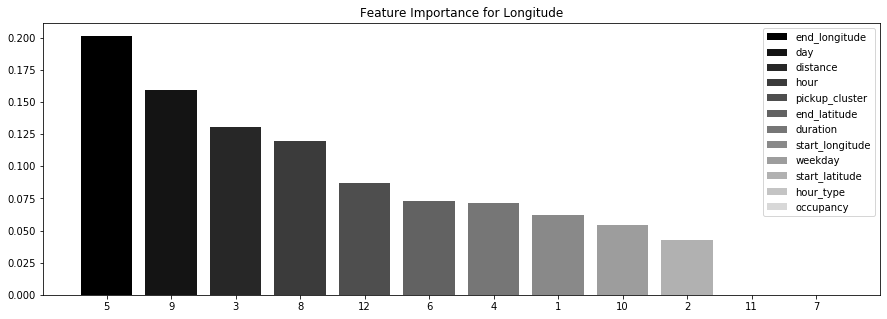

In [75]:
indices = np.argsort(importance_longitude)[::-1]
# Plot the feature importancies of the multivariate xgBoost
num_to_plot = X.columns.shape[0]
feature_indices = [ind+1 for ind in indices[:num_to_plot]]

# Print the feature ranking
print("Feature ranking:")
  
for f in range(num_to_plot):
    print(f"{X.columns[feature_indices[f]-1]}: {importance_longitude[indices[f]]}")
plt.figure(figsize=(15,5))
plt.title(u"Feature Importance for Longitude")
bars = plt.bar(range(num_to_plot), 
               importance_longitude[indices[:num_to_plot]],
       color=([str(i/float(num_to_plot+1)) 
               for i in range(num_to_plot)]),
               align="center")
ticks = plt.xticks(range(num_to_plot), 
                   feature_indices)
# plt.xlim([-1, num_to_plot])
plt.legend(bars, [u''.join(X.columns[i-1]) 
                  for i in feature_indices]);

###### Feature Importance for Latitude

Feature ranking:
end_latitude: 0.16695348918437958
weekday: 0.12837067246437073
hour: 0.12492431700229645
duration: 0.10209932178258896
day: 0.09466691315174103
pickup_cluster: 0.09143248945474625
start_latitude: 0.08974113315343857
distance: 0.07658576220273972
start_longitude: 0.06276173144578934
end_longitude: 0.06246413290500641
hour_type: 0.0
occupancy: 0.0


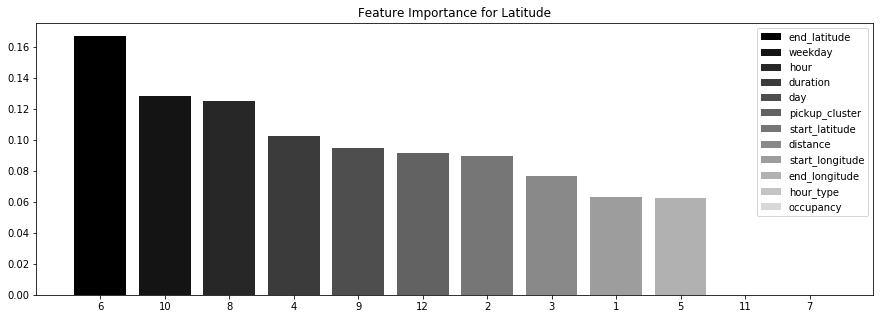

In [76]:
indices = np.argsort(importance_latitude)[::-1]
# Plot the feature importancies of the multivariate xgBoost
num_to_plot = X.columns.shape[0]
feature_indices = [ind+1 for ind in indices[:num_to_plot]]

# Print the feature ranking
print("Feature ranking:")
  
for f in range(num_to_plot):
    print(f"{X.columns[feature_indices[f]-1]}: {importance_latitude[indices[f]]}")
plt.figure(figsize=(15,5))
plt.title(u"Feature Importance for Latitude")
bars = plt.bar(range(num_to_plot), 
               importance_latitude[indices[:num_to_plot]],
       color=([str(i/float(num_to_plot+1)) 
               for i in range(num_to_plot)]),
               align="center")
ticks = plt.xticks(range(num_to_plot), 
                   feature_indices)
# plt.xlim([-1, num_to_plot])
plt.legend(bars, [u''.join(X.columns[i-1]) 
                  for i in feature_indices]);

#### Multivariate Linear Regression

In [77]:
multioutput_lr = MultiOutputRegressor(LinearRegression())
multioutput_lr.fit(X_train, y_train)
y_pred_lr = multioutput_lr.predict(X_test)
print('Mean squared error', mean_squared_error(y_test, y_pred_lr))

Mean squared error 0.0008204498336009008


Coefficients for 2 target variables

In [78]:
multioutput_lr.estimators_[0].coef_

array([ 9.39876217e-02, -2.74916552e-02, -1.86258884e-04, -2.16549609e-04,
        3.29188968e-01,  1.62603600e-02, -2.25687524e-15,  1.36439048e-03,
       -1.54973351e-05, -7.27427113e-04, -5.60685818e-03, -5.47176894e-06])

In [79]:
multioutput_lr.estimators_[1].coef_

array([-1.34215961e-01,  1.63250153e-01,  4.25429906e-04, -2.43703013e-04,
        4.38524847e-02,  6.08673879e-01,  1.00613962e-16, -1.62510594e-03,
        1.31461178e-04,  1.91001051e-03,  5.63383322e-03,  1.22748642e-04])

### Time Series prediction Model (in devolopment)

Given a region and a 10 min interval, we have to predict pickups.

(a): How to break up the San Francisco into regions?

(b): Every region of San Francisco has to be broken up into 10 min interval.

Now, every row pickup has longitude and latitude in it, and we will use this to define pickup regions.
We already know, about the pickup at time ‘t’, we will predict the pickup at time ‘t+1’ in the same region. Hence, this problem can be thought of as a ‘*Time Series Prediction*’ problem. It is a special case of regression problems. In short, we will use the data at time ‘t’ to predict for time ‘t+1’.